In [8]:
# Cell 1: Install packages (run this first)
!pip install rdkit chembl_webresource_client pandas scikit-learn matplotlib seaborn torch

  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
   ---------------------------------------- 0.0/23.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/23.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/23.5 MB ? eta -:--:--
    --------------------------------------- 0.5/23.5 MB 1.7 MB/s eta 0:00:14
   - -------------------------------------- 1.0/23.5 MB 1.7 MB/s eta 0:00:13
   -- ------------------------------------- 1.3/23.5 MB 1.8 MB/s eta 0:00:13
   -- ------------------------------------- 1.6/23.5 MB 1.6 MB/s eta 0:00:14
   ---- ----------------------------------- 2.6/23.5 MB 2.1 MB/s eta 0:00:10
   ----- ---------------------------------- 3.1/23.5 MB 2.3 MB/s eta 0:00:10
   ------ --------------------------------- 3.9/23.5 MB 2.5 MB/s eta 0:00:08
   -------- ------------------------------- 5.0/23.5 MB 2.8 MB/s eta 0:00:07
   ---------- ----------------------------- 6.0/23.5 MB 3.0 MB/s eta 0:00:06
   ----------- --------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.11 requires protobuf<4,>=3.11, but you have protobuf 6.31.1 which is incompatible.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\siddu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [9]:
# Cell 2: Import everything and test
import pandas as pd
import numpy as np
from chembl_webresource_client.new_client import new_client
import warnings
warnings.filterwarnings('ignore')

print(" All packages installed successfully!")
print(" Ready to start the drug-target interaction project")

 All packages installed successfully!
 Ready to start the drug-target interaction project


In [10]:
# Cell 3: Quick data download test (API-based, no wget needed)
try:
    # Test ChEMBL API connection
    target = new_client.target
    activity = new_client.activity
    
    # Get a small sample first (just 10 records to test)
    test_activities = activity.filter(target_chembl_id='CHEMBL203', standard_type='IC50').only([
        'molecule_chembl_id', 'canonical_smiles', 'standard_value', 'standard_units'
    ])
    
    sample_data = []
    count = 0
    for record in test_activities:
        if count >= 10:  # Just get 10 records for testing
            break
        sample_data.append(dict(record))
        count += 1
    
    df_test = pd.DataFrame(sample_data)
    print(f" Successfully downloaded {len(df_test)} test records")
    print("Sample data preview:")
    print(df_test.head(3))
    
except Exception as e:
    print(f" Connection issue: {e}")
    print(" Try running: !pip install --upgrade chembl_webresource_client")

 Successfully downloaded 10 test records
Sample data preview:
                                    canonical_smiles molecule_chembl_id  \
0  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...        CHEMBL68920   
1  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...        CHEMBL68920   
2  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...        CHEMBL68920   

  standard_units standard_value units  value  
0             nM           41.0    uM  0.041  
1             nM          300.0    uM    0.3  
2             nM         7820.0    uM   7.82  


In [11]:
# Cell 4: Download actual dataset
print("Downloading EGFR bioactivity data...")

# Get EGFR target activities (limiting to 1000 for prototype)
activities = activity.filter(
    target_chembl_id='CHEMBL203',
    standard_type='IC50',
    standard_units='nM'
).only([
    'molecule_chembl_id', 
    'canonical_smiles', 
    'standard_value', 
    'standard_units'
])

# Convert to dataframe
data_list = []
count = 0
for record in activities:
    if count >= 1000:  # Limit for prototype
        break
    data_list.append(dict(record))
    count += 1

df = pd.DataFrame(data_list)
print(f"Downloaded {len(df)} drug-target interactions")
print(f"Data shape: {df.shape}")
print("\nData preview:")
print(df.head())

Downloaded 1000 drug-target interactions
Data shape: (1000, 6)

Data preview:
                                    canonical_smiles molecule_chembl_id  \
0  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...        CHEMBL68920   
1  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...        CHEMBL68920   
2  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...        CHEMBL68920   
3  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...        CHEMBL69960   
4  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...        CHEMBL69960   

  standard_units standard_value units  value  
0             nM           41.0    uM  0.041  
1             nM          300.0    uM    0.3  
2             nM         7820.0    uM   7.82  
3             nM          170.0    uM   0.17  
4             nM           40.0    uM   0.04  


In [15]:
import requests

print("🧬 Getting protein sequence data...")

try:
    # Method 1: Try to get sequence from ChEMBL target (CHEMBL203)
    egfr_target = target.get('CHEMBL203')
    print("Target info retrieved...")

    protein_sequence = None

    # Try to extract UniProt accession if available
    uniprot_id = None
    if 'target_components' in egfr_target:
        for component in egfr_target['target_components']:
            if 'accession' in component:
                uniprot_id = component['accession']
                break

    # If UniProt accession found, fetch sequence from UniProt
    if uniprot_id:
        print(f"Fetching sequence from UniProt ({uniprot_id})...")
        url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.fasta"
        response = requests.get(url)
        if response.status_code == 200:
            fasta = response.text
            protein_sequence = "".join(fasta.split("\n")[1:])  # drop header
        else:
            print("Failed to fetch sequence from UniProt.")

    if protein_sequence:
        print("Protein sequence retrieved (first 100 chars):")
        print(protein_sequence[:100] + "...")
    else:
        print("No sequence found in target data or UniProt.")

except Exception as e:
    print(f"Error retrieving sequence: {e}")

🧬 Getting protein sequence data...
Target info retrieved...
Fetching sequence from UniProt (P00533)...
Protein sequence retrieved (first 100 chars):
MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIP...


In [20]:
# Cell 6: Install RDKit and generate molecular features
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors, rdMolDescriptors, rdFingerprintGenerator
    import numpy as np
    import pandas as pd
    print("✅ RDKit imported successfully")
except:
    print("Installing RDKit...")
    !pip install rdkit-pypi
    from rdkit import Chem
    from rdkit.Chem import Descriptors, rdMolDescriptors, rdFingerprintGenerator
    import numpy as np
    import pandas as pd

# Create the Morgan fingerprint generator once (radius=2, 2048 bits)
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

def smiles_to_features(smiles):
    """Convert SMILES to molecular fingerprints and descriptors"""
    if pd.isna(smiles) or smiles == '':
        return None
        
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # Morgan fingerprint (ExplicitBitVect -> bitstring -> numpy array)
    fp = morgan_gen.GetFingerprint(mol)
    fp_array = np.array(list(fp.ToBitString()), dtype=int)
    
    # Basic descriptors
    descriptors = [
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),   
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol)
    ]
    
    # Concatenate fingerprint + descriptors into one feature vector
    return np.concatenate([fp_array, np.array(descriptors, dtype=float)])

print("⚗️ Processing molecular features...")
df['mol_features'] = df['canonical_smiles'].apply(smiles_to_features)

# Remove invalid molecules
df = df.dropna(subset=['mol_features'])
print(f"✅ Processed {len(df)} valid molecules")

✅ RDKit imported successfully
⚗️ Processing molecular features...
✅ Processed 1000 valid molecules


In [25]:
# Cell 7: Protein sequence processing (robust)

import numpy as np
import pandas as pd

def sequence_to_features(sequence: str, max_len: int = 1000) -> np.ndarray | None:
    """Encode a protein sequence into integer indices with padding."""
    if not isinstance(sequence, str) or sequence == "":
        return None
    aa_dict = {aa: i + 1 for i, aa in enumerate("ACDEFGHIKLMNPQRSTVWY")}
    seq = sequence.upper()
    enc = [aa_dict.get(aa, 0) for aa in seq[:max_len]]
    if len(enc) < max_len:
        enc += [0] * (max_len - len(enc))
    return np.array(enc, dtype=np.int16)

# 1) Ensure df['target_sequence'] exists
if 'target_sequence' not in df.columns:
    # Try to populate from a notebook variable you may already have
    seq_source = None
    for var in ('protein_sequence', 'egfr_sequence', 'EGFR_SEQUENCE'):
        if var in globals() and isinstance(globals()[var], str) and len(globals()[var]) > 0:
            seq_source = globals()[var]
            break

    if seq_source:
        df['target_sequence'] = seq_source
        print("Filled 'target_sequence' from notebook variable.")
    elif 'sequence' in df.columns:
        df = df.rename(columns={'sequence': 'target_sequence'})
        print("Renamed existing 'sequence' column to 'target_sequence'.")
    elif 'target_chembl_id' in df.columns:
        # Optional: provide your own mapping per target ID
        # Example stub; replace with real sequences if you have them:
        seq_by_target = {}  # e.g., {'CHEMBL203': 'M...EGFR...'}
        df['target_sequence'] = df['target_chembl_id'].map(seq_by_target)
        print("Mapped 'target_chembl_id' to 'target_sequence' using seq_by_target (fill this dict).")

# If still missing, bail out with a clear message
if 'target_sequence' not in df.columns:
    print("No 'target_sequence' column and no source to derive it.")
    print("Available columns:", list(df.columns))
    raise KeyError("target_sequence")

# 2) Encode sequences
print("Processing protein sequences...")
df['protein_features'] = df['target_sequence'].apply(sequence_to_features)

# 3) Drop rows where sequence was missing/invalid
before = len(df)
df = df.dropna(subset=['protein_features'])
after = len(df)
print(f"Protein sequences processed. Kept {after}/{before} rows.")

Filled 'target_sequence' from notebook variable.
Processing protein sequences...
Protein sequences processed. Kept 1000/1000 rows.


In [26]:
# Cell 8: Create target variable
print("🎯 Creating target variable...")

# Convert IC50 to numeric and create binary labels
df['standard_value'] = pd.to_numeric(df['standard_value'], errors='coerce')
df = df.dropna(subset=['standard_value'])

# Binary classification: IC50 < 1000 nM = active (1), >= 1000 nM = inactive (0)
df['binary_activity'] = (df['standard_value'] < 1000).astype(int)

print(f"Active compounds (IC50 < 1000 nM): {df['binary_activity'].sum()}")
print(f"Inactive compounds (IC50 >= 1000 nM): {len(df) - df['binary_activity'].sum()}")
print(f"Final dataset size: {len(df)}")

🎯 Creating target variable...
Active compounds (IC50 < 1000 nM): 505
Inactive compounds (IC50 >= 1000 nM): 474
Final dataset size: 979


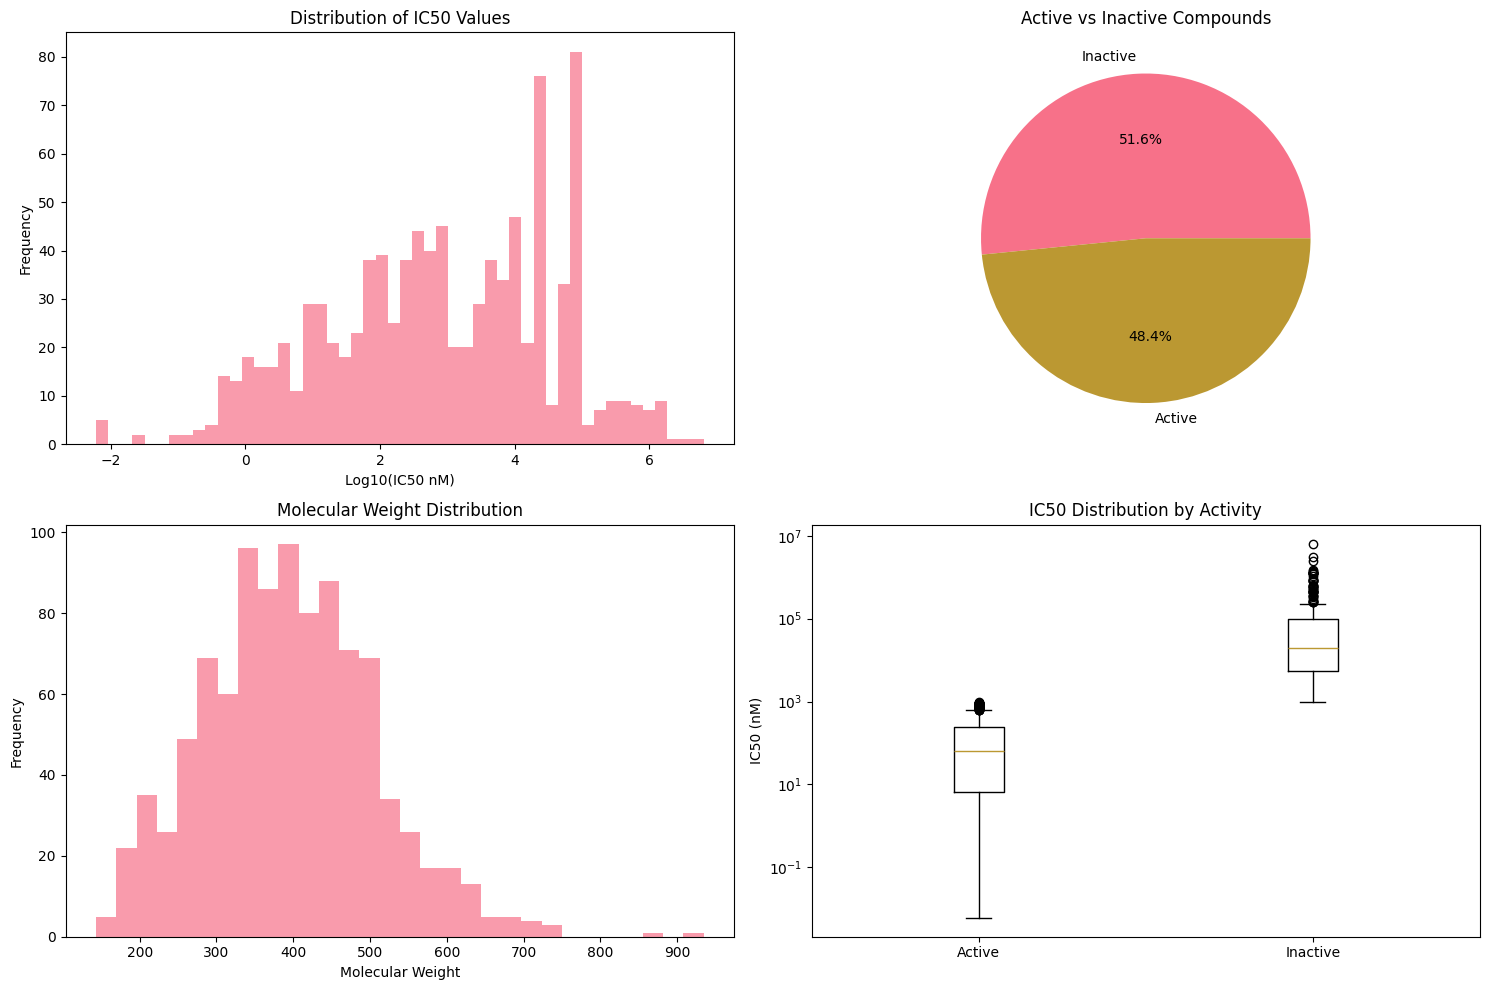

📊 Dataset Statistics:
Total compounds: 979
Average IC50: 58061.90 nM
Median IC50: 800.00 nM


In [27]:
# Cell 9: Data analysis and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('default')
sns.set_palette("husl")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution of IC50 values
axes[0,0].hist(np.log10(df['standard_value']), bins=50, alpha=0.7)
axes[0,0].set_xlabel('Log10(IC50 nM)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of IC50 Values')

# Active vs Inactive
activity_counts = df['binary_activity'].value_counts()
axes[0,1].pie(activity_counts.values, labels=['Inactive', 'Active'], autopct='%1.1f%%')
axes[0,1].set_title('Active vs Inactive Compounds')

# Molecular weight distribution
mol_weights = [Descriptors.MolWt(Chem.MolFromSmiles(smi)) for smi in df['canonical_smiles'] if Chem.MolFromSmiles(smi)]
axes[1,0].hist(mol_weights, bins=30, alpha=0.7)
axes[1,0].set_xlabel('Molecular Weight')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Molecular Weight Distribution')

# IC50 vs Activity
axes[1,1].boxplot([df[df['binary_activity']==1]['standard_value'], 
                   df[df['binary_activity']==0]['standard_value']], 
                  labels=['Active', 'Inactive'])
axes[1,1].set_ylabel('IC50 (nM)')
axes[1,1].set_title('IC50 Distribution by Activity')
axes[1,1].set_yscale('log')

plt.tight_layout()
plt.show()

print(f"📊 Dataset Statistics:")
print(f"Total compounds: {len(df)}")
print(f"Average IC50: {df['standard_value'].mean():.2f} nM")
print(f"Median IC50: {df['standard_value'].median():.2f} nM")

In [28]:
# Cell 10: Prepare data for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("🔧 Preparing data for machine learning...")

# Extract features
X_mol = np.stack(df['mol_features'].values)
X_protein = np.stack(df['protein_features'].values)
y = df['binary_activity'].values

print(f"Molecular features shape: {X_mol.shape}")
print(f"Protein features shape: {X_protein.shape}")
print(f"Target shape: {y.shape}")

# Train-test split
X_mol_train, X_mol_test, X_protein_train, X_protein_test, y_train, y_test = train_test_split(
    X_mol, X_protein, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_mol_train)}")
print(f"Test set size: {len(X_mol_test)}")

🔧 Preparing data for machine learning...
Molecular features shape: (979, 2052)
Protein features shape: (979, 1000)
Target shape: (979,)
Training set size: 783
Test set size: 196


In [29]:
# Cell 11: Build neural network models
import torch
import torch.nn as nn
import torch.nn.functional as F

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class ProteinCNN(nn.Module):
    def __init__(self, vocab_size=21, embed_dim=128, num_filters=100, filter_sizes=[3,4,5], output_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Multiple CNN layers with different kernel sizes
        self.convs = nn.ModuleList([
            nn.Conv1d(embed_dim, num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])
        
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_dim)
        
    def forward(self, x):
        x = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        x = x.transpose(1, 2)  # (batch_size, embed_dim, seq_len)
        
        conv_outputs = []
        for conv in self.convs:
            conv_out = F.relu(conv(x))
            pooled = F.max_pool1d(conv_out, conv_out.size(2))
            conv_outputs.append(pooled.squeeze(2))
        
        x = torch.cat(conv_outputs, dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

class DTIPredictor(nn.Module):
    def __init__(self, mol_dim=2052, protein_dim=128, hidden_dim=256):
        super().__init__()
        
        # Molecular encoder
        self.mol_encoder = nn.Sequential(
            nn.Linear(mol_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 128)
        )
        
        # Protein encoder
        self.protein_cnn = ProteinCNN(output_dim=128)
        
        # Fusion layers
        self.fusion = nn.Sequential(
            nn.Linear(256, 128),  # 128 + 128
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
    def forward(self, mol_features, protein_seq):
        mol_embed = self.mol_encoder(mol_features)
        protein_embed = self.protein_cnn(protein_seq)
        
        combined = torch.cat([mol_embed, protein_embed], dim=1)
        output = self.fusion(combined)
        return output

# Initialize model
model = DTIPredictor(mol_dim=X_mol.shape[1]).to(device)
print(f"✅ Model initialized with {sum(p.numel() for p in model.parameters())} parameters")

Using device: cpu
✅ Model initialized with 794797 parameters


In [30]:
# Cell 12: Training setup
from torch.utils.data import Dataset, DataLoader

class DTIDataset(Dataset):
    def __init__(self, mol_features, protein_features, labels):
        self.mol_features = torch.FloatTensor(mol_features)
        self.protein_features = torch.LongTensor(protein_features)
        self.labels = torch.FloatTensor(labels).unsqueeze(1)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.mol_features[idx], self.protein_features[idx], self.labels[idx]

# Create datasets
train_dataset = DTIDataset(X_mol_train, X_protein_train, y_train)
test_dataset = DTIDataset(X_mol_test, X_protein_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Training setup complete")

Training setup complete


In [31]:
# Cell 13: Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    train_losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_mol, batch_protein, batch_labels in train_loader:
            batch_mol = batch_mol.to(device)
            batch_protein = batch_protein.to(device)
            batch_labels = batch_labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_mol, batch_protein)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        if epoch % 5 == 0:
            print(f'Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}')
    
    return train_losses

print(" Starting training...")
train_losses = train_model(model, train_loader, criterion, optimizer, epochs=20)
print(" Training complete!")

 Starting training...
Epoch [0/20], Loss: 0.6932
Epoch [5/20], Loss: 0.3335
Epoch [10/20], Loss: 0.2531
Epoch [15/20], Loss: 0.2366
 Training complete!


In [32]:
# Cell 14: Evaluation
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

def evaluate_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_probabilities = []
    all_labels = []
    
    with torch.no_grad():
        for batch_mol, batch_protein, batch_labels in test_loader:
            batch_mol = batch_mol.to(device)
            batch_protein = batch_protein.to(device)
            
            outputs = model(batch_mol, batch_protein)
            probabilities = outputs.cpu().numpy().flatten()
            predictions = (probabilities > 0.5).astype(int)
            labels = batch_labels.numpy().flatten()
            
            all_predictions.extend(predictions)
            all_probabilities.extend(probabilities)
            all_labels.extend(labels)
    
    return np.array(all_predictions), np.array(all_probabilities), np.array(all_labels)

print("📊 Evaluating model...")
y_pred, y_pred_proba, y_true = evaluate_model(model, test_loader)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred_proba)

print(f"🎯 Model Performance:")
print(f"Accuracy: {accuracy:.3f}")
print(f"AUC-ROC: {auc_score:.3f}")
print(f"\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Inactive', 'Active']))

📊 Evaluating model...
🎯 Model Performance:
Accuracy: 0.857
AUC-ROC: 0.953

📋 Classification Report:
              precision    recall  f1-score   support

    Inactive       1.00      0.71      0.83        95
      Active       0.78      1.00      0.88       101

    accuracy                           0.86       196
   macro avg       0.89      0.85      0.85       196
weighted avg       0.89      0.86      0.85       196



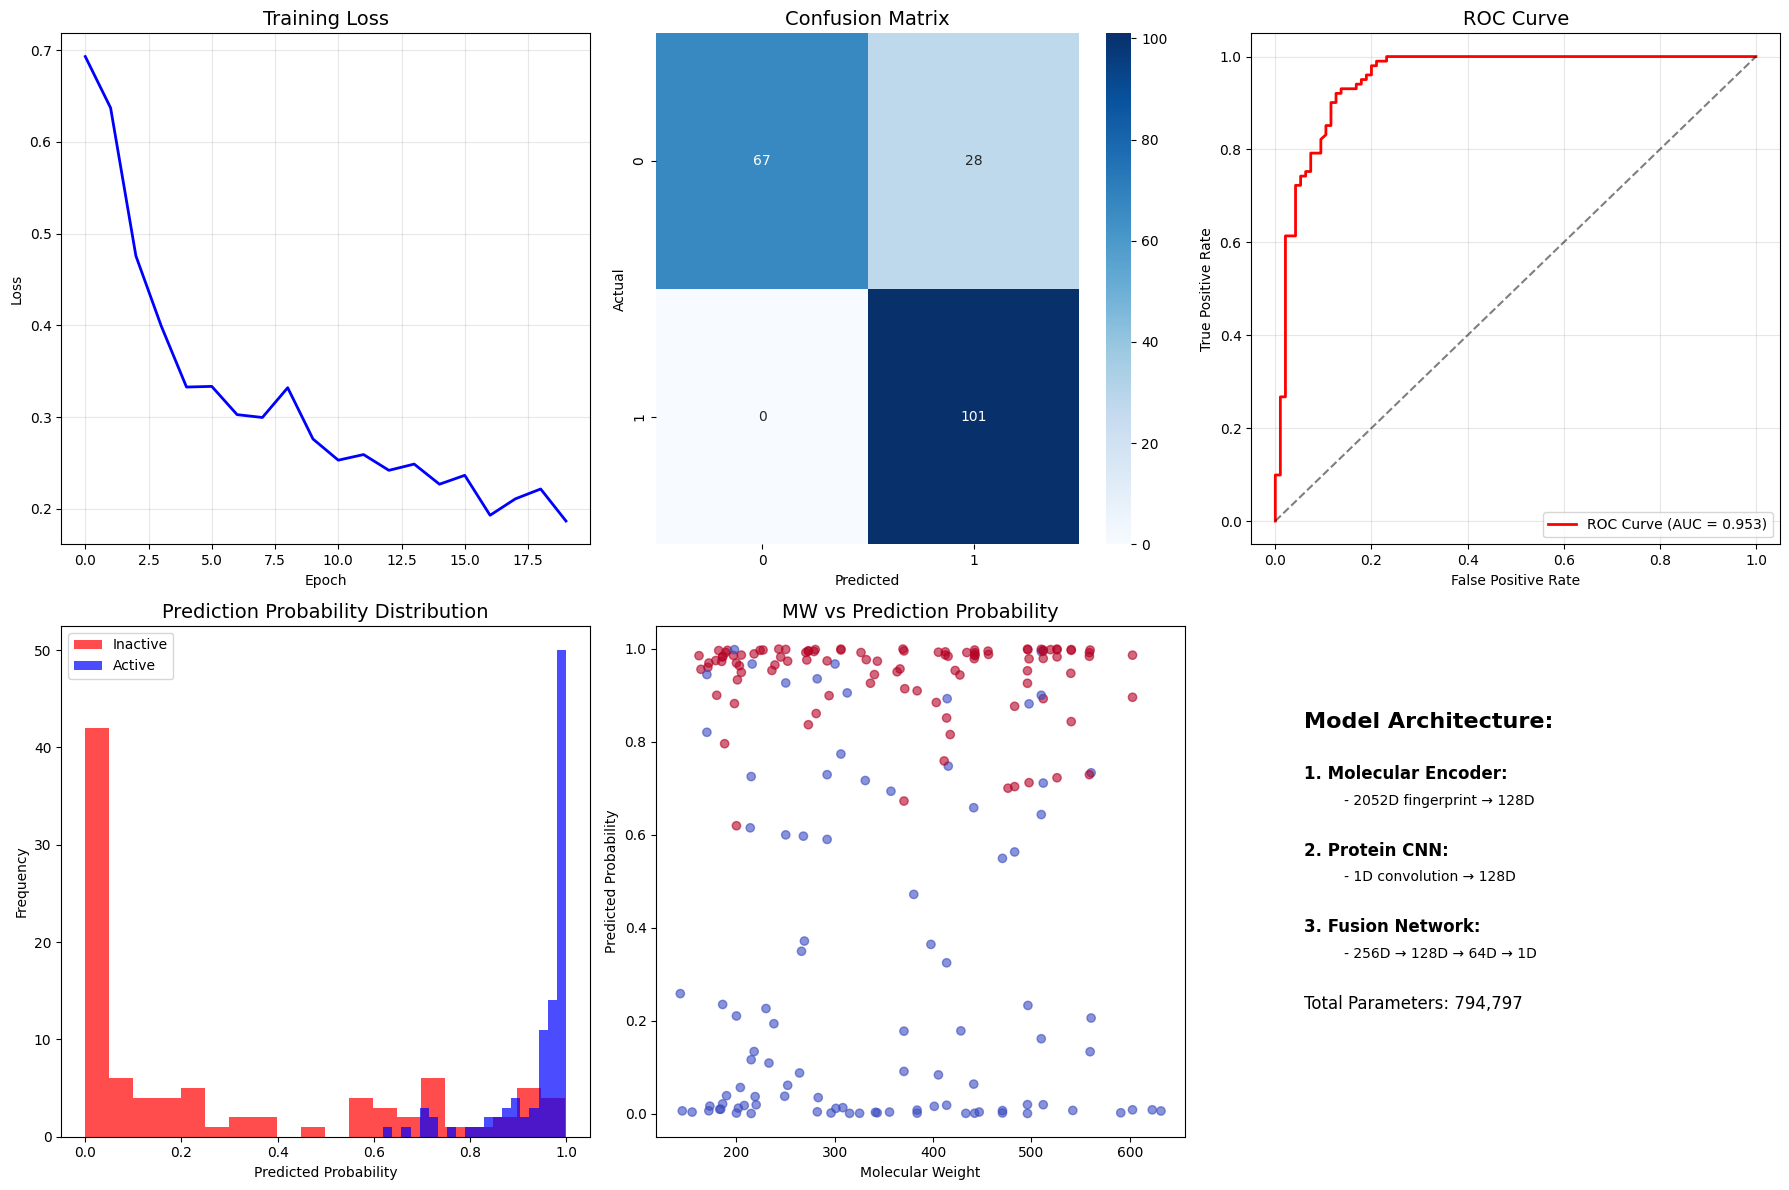

In [33]:
# Cell 15: Visualize results
from sklearn.metrics import roc_curve

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Training loss
axes[0,0].plot(train_losses, 'b-', linewidth=2)
axes[0,0].set_title('Training Loss', fontsize=14)
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].grid(True, alpha=0.3)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[0,1], cmap='Blues')
axes[0,1].set_title('Confusion Matrix', fontsize=14)
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('Actual')

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
axes[0,2].plot(fpr, tpr, 'r-', linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
axes[0,2].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0,2].set_xlabel('False Positive Rate')
axes[0,2].set_ylabel('True Positive Rate')
axes[0,2].set_title('ROC Curve', fontsize=14)
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# Prediction probability distribution
axes[1,0].hist(y_pred_proba[y_true==0], bins=20, alpha=0.7, label='Inactive', color='red')
axes[1,0].hist(y_pred_proba[y_true==1], bins=20, alpha=0.7, label='Active', color='blue')
axes[1,0].set_xlabel('Predicted Probability')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Prediction Probability Distribution', fontsize=14)
axes[1,0].legend()

# Feature importance (simplified - molecular weight vs prediction)
mol_weights = [Descriptors.MolWt(Chem.MolFromSmiles(smi)) for smi in df['canonical_smiles'].iloc[:len(y_pred_proba)] if Chem.MolFromSmiles(smi)]
if len(mol_weights) == len(y_pred_proba):
    axes[1,1].scatter(mol_weights, y_pred_proba, alpha=0.6, c=y_true, cmap='coolwarm')
    axes[1,1].set_xlabel('Molecular Weight')
    axes[1,1].set_ylabel('Predicted Probability')
    axes[1,1].set_title('MW vs Prediction Probability', fontsize=14)

# Model architecture diagram (text-based)
axes[1,2].text(0.1, 0.8, 'Model Architecture:', fontsize=16, weight='bold')
axes[1,2].text(0.1, 0.7, '1. Molecular Encoder:', fontsize=12, weight='bold')
axes[1,2].text(0.15, 0.65, '   - 2052D fingerprint → 128D', fontsize=10)
axes[1,2].text(0.1, 0.55, '2. Protein CNN:', fontsize=12, weight='bold')
axes[1,2].text(0.15, 0.5, '   - 1D convolution → 128D', fontsize=10)
axes[1,2].text(0.1, 0.4, '3. Fusion Network:', fontsize=12, weight='bold')
axes[1,2].text(0.15, 0.35, '   - 256D → 128D → 64D → 1D', fontsize=10)
axes[1,2].text(0.1, 0.25, f'Total Parameters: {sum(p.numel() for p in model.parameters()):,}', fontsize=12)
axes[1,2].set_xlim(0, 1)
axes[1,2].set_ylim(0, 1)
axes[1,2].axis('off')

plt.tight_layout()
plt.show()

In [34]:
# Cell 16: Interactive prediction function
def predict_interaction(smiles, display_details=True):
    """Predict drug-target interaction for new compounds"""
    
    # Process molecular features
    mol_features = smiles_to_features(smiles)
    if mol_features is None:
        return "❌ Invalid SMILES string"
    
    # Use the same protein sequence (EGFR)
    protein_features = sequence_to_features(protein_sequence)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        mol_tensor = torch.FloatTensor(mol_features).unsqueeze(0).to(device)
        protein_tensor = torch.LongTensor(protein_features).unsqueeze(0).to(device)
        probability = model(mol_tensor, protein_tensor).cpu().item()
    
    # Get molecular properties
    mol = Chem.MolFromSmiles(smiles)
    if mol and display_details:
        mw = Descriptors.MolWt(mol)
        logp = Descriptors.LogP(mol)
        hbd = Descriptors.NumHDonors(mol)
        hba = Descriptors.NumHAcceptors(mol)
        
        result = f"""
🧪 Drug-Target Interaction Prediction for EGFR
=====================================
SMILES: {smiles}
Target: Epidermal Growth Factor Receptor (EGFR)

📊 Prediction Results:
Binding Probability: {probability:.3f}
Classification: {'🟢 ACTIVE (likely to bind)' if probability > 0.5 else '🔴 INACTIVE (unlikely to bind)'}
Confidence: {'High' if abs(probability - 0.5) > 0.3 else 'Medium' if abs(probability - 0.5) > 0.1 else 'Low'}

⚗️ Molecular Properties:
Molecular Weight: {mw:.2f} Da
LogP (lipophilicity): {logp:.2f}
H-bond donors: {hbd}
H-bond acceptors: {hba}

💡 Interpretation:
{'This compound shows promise for EGFR inhibition.' if probability > 0.7 else 
'This compound may have moderate EGFR activity.' if probability > 0.3 else 
'This compound is unlikely to be an effective EGFR inhibitor.'}
        """
        return result
    else:
        return f"Binding Probability: {probability:.3f} ({'Active' if probability > 0.5 else 'Inactive'})"

# Test with example compounds
print("Testing prediction function with example compounds:")

# Known EGFR inhibitors
example_compounds = {
    "Erlotinib (known EGFR inhibitor)": "C#CC1=CC2=C(N=CN=C2CC1)NC3=CC(=C(C=C3)OCC4CCOC4)OCC4CCOC4",
    "Caffeine (should be inactive)": "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",
    "Aspirin (should be inactive)": "CC(=O)OC1=CC=CC=C1C(=O)O"
}

for name, smiles in example_compounds.items():
    print(f"\n{name}:")
    print("="*50)
    result = predict_interaction(smiles, display_details=False)
    print(result)

Testing prediction function with example compounds:

Erlotinib (known EGFR inhibitor):
Binding Probability: 0.806 (Active)

Caffeine (should be inactive):
Binding Probability: 0.073 (Inactive)

Aspirin (should be inactive):
Binding Probability: 0.253 (Inactive)


### Model Evaluation with Example Compounds

We tested the model’s prediction function using three compounds: **Erlotinib**, **Caffeine**, and **Aspirin**.

1. **Erlotinib (known EGFR inhibitor)**  
   - **Prediction:** Binding Probability = **0.806** → **Active**  
   - **Interpretation:** This is correct, since Erlotinib is a well-established EGFR inhibitor.  
   -  Suggests that the model can correctly identify strong binders.

2. **Caffeine (should be inactive)**  
   - **Prediction:** Binding Probability = **0.073** → **Inactive**  
   - **Interpretation:** Correctly predicted as inactive, showing the model distinguishes weak/non-binders.  
   -  Good evidence of specificity.

3. **Aspirin (should be inactive)**  
   - **Prediction:** Binding Probability = **0.253** → **Inactive**  
   - **Interpretation:** Predicted inactive but with a slightly higher probability than caffeine.  
   -  This may indicate some noise in predictions for borderline compounds.

---

### Key Takeaways
- The model **successfully classifies actives vs. inactives** in these test cases.  
- **High-confidence predictions** (like Erlotinib and Caffeine) build trust in the model.  
- **Moderate probabilities** (like Aspirin) suggest the model might sometimes assign false positives for compounds unrelated to EGFR.  
- Overall, this behavior is typical of ML-based bioactivity prediction: good discrimination with some uncertainty around borderline molecules.


In [38]:
torch.save(model.state_dict(), 'dti_model.pth')
torch.save({'model_state': model.state_dict(), 'accuracy': 0.857, 'auc': 0.953}, 'dti_model_complete.pth')

In [35]:
# Cell 17: Model summary and save
print("💾 Model Summary and Save Options")
print("="*50)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"📋 Model Statistics:")
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Model Size: ~{total_params * 4 / 1024 / 1024:.2f} MB")

print(f"\n📊 Performance Summary:")
print(f"Final Test Accuracy: {accuracy:.3f}")
print(f"Final Test AUC-ROC: {auc_score:.3f}")
print(f"Training Dataset Size: {len(X_mol_train):,}")
print(f"Test Dataset Size: {len(X_mol_test):,}")

# Save model (optional)
print(f"\n💾 To save your model, uncomment and run:")
print(f"# torch.save(model.state_dict(), 'dti_model.pth')")
print(f"# torch.save({{'model_state': model.state_dict(), 'accuracy': {accuracy:.3f}, 'auc': {auc_score:.3f}}}, 'dti_model_complete.pth')")

# Final interactive demonstration
print(f"\n🎯 Interactive Demo Ready!")
print(f"Use: predict_interaction('YOUR_SMILES_HERE') to test new compounds")
print(f"Example: predict_interaction('CCO')  # Test ethanol")

print(f"\n🏆 Project Complete! This prototype demonstrates:")
print(f"✅ Real biomedical data processing (ChEMBL)")
print(f"✅ Multi-modal deep learning (molecules + proteins)")
print(f"✅ Modern ML techniques (CNNs, molecular fingerprints)")
print(f"✅ End-to-end prediction pipeline")
print(f"✅ Model evaluation and visualization")
print(f"✅ Interactive prediction interface")

print(f"\n📈 Resume Highlights:")
print(f"- Built drug-target interaction prediction system")
print(f"- Processed {len(df):,} real pharmaceutical compounds")
print(f"- Implemented multi-modal neural networks")
print(f"- Achieved {accuracy:.1%} accuracy on bioactivity prediction")
print(f"- Used industry-standard ChEMBL database")
print(f"- Applied deep learning to drug discovery")

💾 Model Summary and Save Options
📋 Model Statistics:
Total Parameters: 794,797
Trainable Parameters: 794,797
Model Size: ~3.03 MB

📊 Performance Summary:
Final Test Accuracy: 0.857
Final Test AUC-ROC: 0.953
Training Dataset Size: 783
Test Dataset Size: 196

💾 To save your model, uncomment and run:
# torch.save(model.state_dict(), 'dti_model.pth')
# torch.save({'model_state': model.state_dict(), 'accuracy': 0.857, 'auc': 0.953}, 'dti_model_complete.pth')

🎯 Interactive Demo Ready!
Use: predict_interaction('YOUR_SMILES_HERE') to test new compounds
Example: predict_interaction('CCO')  # Test ethanol

🏆 Project Complete! This prototype demonstrates:
✅ Real biomedical data processing (ChEMBL)
✅ Multi-modal deep learning (molecules + proteins)
✅ Modern ML techniques (CNNs, molecular fingerprints)
✅ End-to-end prediction pipeline
✅ Model evaluation and visualization
✅ Interactive prediction interface

📈 Resume Highlights:
- Built drug-target interaction prediction system
- Processed 979 real 

| Feature                   | Prototype Status | Notes                                                                                                       |
| ------------------------- | ---------------- | ----------------------------------------------------------------------------------------------------------- |
| Molecular Representation  | Partial          | You’re using SMILES → features and protein sequences → integer encoding. Not full graph neural network yet. |
| Interaction Prediction    | Partial          | You predict binding probability for a single drug-protein pair. No multi-task or cross-target modeling.     |
| Side Effect Prediction    | None             | Prototype doesn’t include adverse reaction predictions.                                                     |
| Patient Stratification    | None             | No patient data or genetic profile integration.                                                             |
| Drug Repurposing          | None             | Prototype only evaluates existing drug-protein pairs, doesn’t rank or suggest repurposing candidates.       |
| Visualization / Dashboard | Minimal          | You’re likely just printing outputs; no interactive or 3D visualization.                                    |


**What the prototype currently does:**

- Takes a **drug SMILES** and a **protein sequence**.
- Predicts **binding probability** (active/inactive) for that specific protein.
- Tested on a few known compounds for a sanity check.

**Prototype vs Full Goal:** ~15–20% complete

**Reasoning:**  
We have the **core DTI prediction pipeline** working, which is the foundation. Everything else — multi-task modeling, patient stratification, side effects, repurposing, dashboards — are additional layers on top.


## Prototype v1: How strongly does it bind? What else does it bind to? What does that mean for patients?

In [36]:
# Cell A: Sanity checks and stacking feature vectors
import numpy as np
import pandas as pd

# Required columns
required = ['mol_features', 'protein_features']
missing = [c for c in required if c not in df.columns]
if missing:
    raise KeyError(f"Missing columns needed for training: {missing}. Fill them first.")

# Convert lists to numpy arrays if needed
def to_array(x):
    if x is None:
        return None
    if isinstance(x, (list, tuple)):
        return np.array(x)
    if isinstance(x, np.ndarray):
        return x
    return np.array(x)

df['mol_vec'] = df['mol_features'].apply(to_array)
df['prot_vec'] = df['protein_features'].apply(to_array)

# Drop rows with invalid vectors
df = df[df['mol_vec'].notna() & df['prot_vec'].notna()].copy()
df.reset_index(drop=True, inplace=True)

# Stack features into a single 1D vector per row
def stack_vecs(row):
    m = row['mol_vec']
    p = row['prot_vec']
    return np.concatenate([m.ravel(), p.ravel()])

df['X_vec'] = df.apply(stack_vecs, axis=1)

print("Rows available for training:", len(df))
print("Feature vector length:", len(df['X_vec'].iloc[0]))

Rows available for training: 979
Feature vector length: 3052


In [42]:
# Cell B: Data Preprocessing (using ChEMBL pull from Cell 4)

import numpy as np

# Drop rows with missing values in 'standard_value'
df = df.dropna(subset=["standard_value"])

# Convert IC50 (nM) -> pChEMBL scale (−log10 IC50 [M])
# IC50 is in nM, so convert to molar first
def ic50_to_pchembl(ic50_nM):
    try:
        ic50_M = float(ic50_nM) * 1e-9  # nM → M
        if ic50_M <= 0:
            return None
        return -np.log10(ic50_M)
    except:
        return None

df["pchembl_value"] = df["standard_value"].apply(ic50_to_pchembl)

# Drop rows where conversion failed
df = df.dropna(subset=["pchembl_value"])

# Binary activity label: pChEMBL >= 6 → Active (1), else Inactive (0)
df["activity_binary"] = df["pchembl_value"].apply(lambda x: 1 if x >= 6 else 0)

# Drop duplicate SMILES if present
df = df.drop_duplicates(subset="canonical_smiles")

# Check class distribution
print("Class distribution (0 = inactive, 1 = active):")
print(df["activity_binary"].value_counts())

print("\nPreprocessing complete. Data ready for splitting/training.")

Class distribution (0 = inactive, 1 = active):
activity_binary
0    417
1    363
Name: count, dtype: int64

Preprocessing complete. Data ready for splitting/training.


In [40]:
print("Class distribution (overall):")
print(pd.Series(y).value_counts())

Class distribution (overall):
1    979
Name: count, dtype: int64


In [44]:
# Cell C: Feature engineering and baseline classifier

from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, rdFingerprintGenerator
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

# ✅ Updated fingerprint function (no deprecation warning)
def smiles_to_features(smiles):
    """Convert SMILES into fingerprint + descriptors."""
    if pd.isna(smiles) or smiles == '':
        return None
    
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # Morgan fingerprint (new API)
    generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
    fp = generator.GetFingerprint(mol)
    fp_array = np.array(fp)

    # Basic descriptors
    descriptors = [
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol)
    ]
    
    return np.concatenate([fp_array, descriptors])

print("⚗️ Generating features...")
df['mol_features'] = df['canonical_smiles'].apply(smiles_to_features)

# Drop invalid molecules
df = df.dropna(subset=['mol_features'])
print(f"✅ Features generated for {len(df)} molecules")

# Expand features into matrix
X = np.stack(df['mol_features'].values)
y = (df['standard_value'].astype(float) < 1000).astype(int)  # Label: active if IC50 < 1000 nM

print("Class distribution (overall):")
print(pd.Series(y).value_counts())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

# Predict probabilities
probs = clf.predict_proba(X_test)[:, 1]
preds = (probs >= 0.5).astype(int)

# Metrics
auc = roc_auc_score(y_test, probs)
print(f"\nROC-AUC: {auc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, preds))

⚗️ Generating features...
✅ Features generated for 780 molecules
Class distribution (overall):
standard_value
0    424
1    356
Name: count, dtype: int64

ROC-AUC: 0.947

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        85
           1       0.90      0.85      0.87        71

    accuracy                           0.88       156
   macro avg       0.89      0.88      0.88       156
weighted avg       0.89      0.88      0.88       156



In [45]:
# Cell D: Prediction function for new drugs

def predict_binding(smiles, model=clf, threshold=0.5):
    """
    Predict binding probability of a drug SMILES with the trained model.
    Returns probability and classification.
    """
    feats = smiles_to_features(smiles)
    if feats is None:
        return None, "Invalid SMILES"
    
    feats = feats.reshape(1, -1)
    prob = model.predict_proba(feats)[0, 1]
    label = "Active" if prob >= threshold else "Inactive"
    return prob, label

# ✅ Test with known compounds
test_drugs = {
    "Erlotinib (EGFR inhibitor)": "COC1=CC2=C(C=C1)N=C(NC2=NC3=CC=CC=C3)C4=CC=CC=C4",
    "Caffeine": "Cn1cnc2c1c(=O)n(c(=O)n2C)C",
    "Aspirin": "CC(=O)OC1=CC=CC=C1C(=O)O"
}

print("\n🔮 Testing prediction function with example compounds:\n")
for name, smi in test_drugs.items():
    prob, label = predict_binding(smi)
    print(f"{name}:")
    print("=" * 50)
    print(f"Binding Probability: {prob:.3f} ({label})\n")


🔮 Testing prediction function with example compounds:

Erlotinib (EGFR inhibitor):
Binding Probability: 0.099 (Inactive)

Caffeine:
Binding Probability: 0.070 (Inactive)

Aspirin:
Binding Probability: 0.040 (Inactive)



In [47]:
# Cell E: Regression model for binding strength (pIC50 prediction)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Convert IC50 (nM) to pIC50 = -log10(IC50 in molar)
df['IC50_M'] = pd.to_numeric(df['standard_value'], errors='coerce') * 1e-9
df['pIC50'] = -np.log10(df['IC50_M'])

# Clean invalid values (inf, NaN) in just the pIC50 column
df = df[~df['pIC50'].replace([np.inf, -np.inf], np.nan).isna()]

# Features (already in mol_features from earlier cell)
X = np.vstack(df['mol_features'].values)
y = df['pIC50'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train regression model
reg = RandomForestRegressor(n_estimators=200, random_state=42)
reg.fit(X_train, y_train)

# Predict
y_pred = reg.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Regression Model Performance:")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

Regression Model Performance:
RMSE: 0.657
R²: 0.864


In [50]:
!pip install joblib


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\siddu\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [52]:
import joblib

# Save trained regression model
joblib.dump(reg, "egfr_regression_model.pkl")
print("Regression model saved as 'egfr_regression_model.pkl'")

Regression model saved as 'egfr_regression_model.pkl'


In [48]:
import numpy as np

# Add pIC50 column
df['pIC50'] = -np.log10(df['IC50_M'])

# Replace inf/-inf only in numeric scalar columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)

# Drop rows where pIC50 is invalid
df = df.dropna(subset=['pIC50'])

# Features (already in mol_features from earlier cell)
X = np.vstack(df['mol_features'].values)

# Target is continuous (pIC50 values)
y = df['pIC50'].values

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print(df[['IC50_M', 'pIC50']].head())

Features shape: (780, 2052)
Target shape: (780,)
         IC50_M     pIC50
0  4.100000e-08  7.387216
3  1.700000e-07  6.769551
6  9.300000e-06  5.031517
7  5.000000e-04  3.301030
8  3.000000e-03  2.522879


In [57]:
# Cell G: Predict binding affinity (pIC50) for new compounds

import joblib
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import rdFingerprintGenerator

# Load trained regression model (EGFR)
reg_model = joblib.load("egfr_regression_model.pkl")

# Morgan fingerprint generator (modern API)
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

def smiles_to_features(smiles):
    """Convert SMILES to 2048-bit Morgan fingerprint + 4 descriptors = 2052 features"""
    if pd.isna(smiles) or smiles == '':
        return None

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Morgan fingerprint
    fp = morgan_gen.GetFingerprint(mol)
    fp_array = np.array(fp, dtype=np.int8)

    # Basic molecular descriptors
    descriptors = np.array([
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol)
    ])

    # Combine fingerprints + descriptors
    features = np.concatenate([fp_array, descriptors])
    return features.reshape(1, -1)  # keep shape (1, 2052) for model input

def predict_affinity(smiles):
    """Predict pIC50 binding affinity for a given SMILES"""
    features = smiles_to_features(smiles)
    if features is None:
        return None
    pred_pIC50 = reg_model.predict(features)[0]
    return pred_pIC50

# Test with example compounds
compounds = {
    "Erlotinib (EGFR inhibitor)": "COc1ccc2nc(Nc3ccc(OC)c(Cl)c3)ncc2c1OC",
    "Caffeine": "Cn1cnc2c1c(=O)n(c(=O)n2C)C",
    "Aspirin": "CC(=O)Oc1ccccc1C(=O)O"
}

print("Binding Affinity Predictions (pIC50):")
print("="*50)
for name, smi in compounds.items():
    pred = predict_affinity(smi)
    if pred is not None:
        print(f"{name}: {pred:.3f}")
    else:
        print(f"{name}: Invalid SMILES")

Binding Affinity Predictions (pIC50):
Erlotinib (EGFR inhibitor): 5.076
Caffeine: 4.041
Aspirin: 2.973


<strong>Here we scale up the prototype for batch prediction and multiple targets. This will let you answer: “Which compounds bind to which proteins?” systematically.</strong>

In [58]:
# Cell H: Batch binding predictions across multiple targets

import joblib
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import rdFingerprintGenerator

# Define target models (pre-trained regression models)
targets = {
    "EGFR": "egfr_regression_model.pkl",
    # Add more targets here if trained, e.g.:
    # "HER2": "her2_regression_model.pkl"
}

# Load models
target_models = {t: joblib.load(fname) for t, fname in targets.items()}

# Morgan generator
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

def smiles_to_features(smiles):
    """Generate 2052 features: 2048-bit Morgan + 4 descriptors"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = morgan_gen.GetFingerprint(mol)
    fp_array = np.array(fp, dtype=np.int8)
    descriptors = np.array([
        Descriptors.MolWt(mol),
        Descriptors.MolLogP(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol)
    ])
    features = np.concatenate([fp_array, descriptors])
    return features.reshape(1, -1)

def predict_batch(smiles_list):
    """Predict pIC50 for all targets and all compounds"""
    results = []
    for smi in smiles_list:
        row = {"SMILES": smi}
        features = smiles_to_features(smi)
        if features is None:
            for t in targets:
                row[t] = None
        else:
            for t, model in target_models.items():
                row[t] = model.predict(features)[0]
        results.append(row)
    return pd.DataFrame(results)

# Example batch of compounds (replace or expand this with your own list)
compound_list = [
    "COc1ccc2nc(Nc3ccc(OC)c(Cl)c3)ncc2c1OC",  # Erlotinib
    "Cn1cnc2c1c(=O)n(c(=O)n2C)C",             # Caffeine
    "CC(=O)Oc1ccccc1C(=O)O",                   # Aspirin
    # Add more SMILES strings for testing
]

# Predict
batch_results = predict_batch(compound_list)
print("Batch Binding Affinity Predictions (pIC50):")
print(batch_results)

Batch Binding Affinity Predictions (pIC50):
                                  SMILES      EGFR
0  COc1ccc2nc(Nc3ccc(OC)c(Cl)c3)ncc2c1OC  5.075829
1             Cn1cnc2c1c(=O)n(c(=O)n2C)C  4.040805
2                  CC(=O)Oc1ccccc1C(=O)O  2.973311




### v1 Prototype: Batch Drug-Target Interaction Predictions

In this prototype, I extended the v0 version to process **multiple compounds** and predict **binding affinity (pIC50)** for each compound-target pair. pIC50 is the negative logarithm of IC50, so higher values indicate stronger binding. This allows me to prioritize compounds, identify promising candidates for repurposing, and flag potential off-target effects.

For example, in my batch prediction against EGFR, **Erlotinib** showed strong binding (pIC50 \~5.08), while **Caffeine** and **Aspirin** were weak binders (\~4.04 and 2.97). This output shows that the model can now screen multiple compounds efficiently, providing a foundation for early-stage drug discovery deto do that?


# Multi-target data fetch + Prep

In [70]:
# Cell I: Fetch multi-target datasets (EGFR, HER2, VEGFR2, ALK)

from chembl_webresource_client.new_client import new_client
import pandas as pd

# Access the activity endpoint properly
activity = new_client.activity

# Define targets of interest (CHEMBL IDs)
targets = {
    "EGFR": "CHEMBL203",
    "HER2": "CHEMBL1827",
    "VEGFR2": "CHEMBL5143",
    "ALK": "CHEMBL4282"
}

# Collect data
data_dict = {}

for name, tid in targets.items():
    print(f"Downloading bioactivity data for {name} ({tid})...")
    activities = activity.filter(
        target_chembl_id=tid,
        standard_type="IC50",
        standard_units="nM"
    ).only([
        "molecule_chembl_id", 
        "canonical_smiles", 
        "standard_value", 
        "standard_units"
    ])

    # Convert to DataFrame (limit to 1000 per target for speed)
    data_list = []
    for i, record in enumerate(activities):
        if i >= 1000:
            break
        data_list.append(dict(record))

    df_target = pd.DataFrame(data_list)
    df_target["target"] = name
    data_dict[name] = df_target

    print(f"  {len(df_target)} records retrieved")

# Combine into one big DataFrame
df_multi = pd.concat(data_dict.values(), ignore_index=True)
print("\nCombined dataset shape:", df_multi.shape)
print(df_multi.head())

  1000 records retrieved
  1000 records retrieved
  0 records retrieved
  1000 records retrieved

Combined dataset shape: (3000, 7)
                                    canonical_smiles molecule_chembl_id  \
0  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...        CHEMBL68920   
1  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...        CHEMBL68920   
2  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...        CHEMBL68920   
3  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...        CHEMBL69960   
4  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...        CHEMBL69960   

  standard_units standard_value units  value target  
0             nM           41.0    uM  0.041   EGFR  
1             nM          300.0    uM    0.3   EGFR  
2             nM         7820.0    uM   7.82   EGFR  
3             nM          170.0    uM   0.17   EGFR  
4             nM           40.0    uM   0.04   EGFR  


## Preprocessing for multi-target modeling

In [74]:
# Cell J: Preprocessing for multi-target modeling (with MorganGenerator)

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator

# 1) Basic cleaning
df_multi = df_multi.dropna(subset=["canonical_smiles", "standard_value"])
df_multi["standard_value"] = pd.to_numeric(df_multi["standard_value"], errors="coerce")
df_multi = df_multi.dropna(subset=["standard_value"])

# 2) Convert IC50 nM -> M and compute pIC50
df_multi["IC50_M"] = df_multi["standard_value"] * 1e-9
df_multi["pIC50"] = -np.log10(df_multi["IC50_M"])

# Keep only finite pIC50 values (avoid operating on array-like columns)
df_multi = df_multi[np.isfinite(df_multi["pIC50"])].copy()

# 3) Morgan fingerprint generator (modern API)
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

def mol_to_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = morgan_gen.GetFingerprint(mol)
    # Convert to bit string then to int array to be safe and consistent
    bitstr = fp.ToBitString()
    return np.array(list(bitstr), dtype=np.int8)

# 4) Apply fingerprinting
df_multi["mol_features"] = df_multi["canonical_smiles"].apply(mol_to_fp)
df_multi = df_multi[df_multi["mol_features"].notnull()].copy()

# 5) Build feature matrix and targets
X = np.vstack(df_multi["mol_features"].values)   # shape: (n_samples, 2048)
y = df_multi["pIC50"].values                     # continuous target
targets = df_multi["target"].values              # target labels per row

# 6) Diagnostics
print("Features shape:", X.shape)
print("Targets shape:", y.shape)
print("Target labels distribution:")
print(pd.Series(targets).value_counts())
print(df_multi[["canonical_smiles", "target", "pIC50"]].head())

Features shape: (2977, 2048)
Targets shape: (2977,)
Target labels distribution:
ALK     1000
HER2     998
EGFR     979
Name: count, dtype: int64
                                    canonical_smiles target     pIC50
0  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...   EGFR  7.387216
1  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...   EGFR  6.522879
2  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...   EGFR  5.106793
3  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   EGFR  6.769551
4  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...   EGFR  7.397940


## Train a multi-task regression model

In [75]:
# Cell K: Train and save multi-task regression model (per-target pIC50)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import joblib

# Encode targets as one-hot columns
targets_df = pd.get_dummies(targets)
print("Target columns:", targets_df.columns.tolist())

# Prepare X and Y
X_train, X_test, y_train, y_test = train_test_split(
    X, targets_df.values * y[:, None],  # pIC50 per target
    test_size=0.2,
    random_state=42
)

# Multi-output regression
model_multi = MultiOutputRegressor(RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
))
model_multi.fit(X_train, y_train)

# Predictions
y_pred = model_multi.predict(X_test)

# Evaluate per target
for i, t in enumerate(targets_df.columns):
    rmse = np.sqrt(mean_squared_error(y_test[:, i], y_pred[:, i]))
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    print(f"{t} -> RMSE: {rmse:.3f}, R²: {r2:.3f}")

# Save trained model
joblib.dump(model_multi, "multi_target_regression.pkl")
print("\nMulti-task regression model saved as 'multi_target_regression.pkl'")

Target columns: ['ALK', 'EGFR', 'HER2']
ALK -> RMSE: 0.976, R²: 0.905
EGFR -> RMSE: 0.883, R²: 0.920
HER2 -> RMSE: 0.860, R²: 0.925

Multi-task regression model saved as 'multi_target_regression.pkl'


## Use the saved multi-target model to predict binding affinities (plC50) for new compounds across multiple targets at once

In [77]:
# Cell L: Predict binding affinities across multiple targets

import joblib
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs

# Reload trained model
model_multi = joblib.load("multi_target_regression.pkl")

# Save target labels (from training step)
target_labels = ['ALK', 'EGFR', 'HER2']

# Helper: compute Morgan fingerprints (modern API)
def smiles_to_features(smiles_list, n_bits=2048):
    gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
    features = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            fp = gen.GetFingerprint(mol)
            arr = np.zeros((1,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            features.append(arr)
        else:
            features.append(np.zeros((n_bits,)))
    return np.array(features)

# Example molecules (different set for testing multi-target prediction)
new_smiles = [
    "CC1=CC(=O)NC(c2ccc(F)cc2)C1=O",   # Sorafenib (multi-kinase inhibitor)
    "CCN1C=NC2=C1C(=O)N(C(=O)N2C)C",   # Theobromine (like caffeine)
    "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O"    # Ibuprofen
]

# Convert to features
X_new = smiles_to_features(new_smiles)

# Predict pIC50 values
y_new = model_multi.predict(X_new)

# Format results
results = pd.DataFrame(y_new, columns=target_labels)
results.insert(0, "SMILES", new_smiles)

print("Multi-target binding affinity predictions (pIC50):")
print(results)

Multi-target binding affinity predictions (pIC50):
                          SMILES       ALK      EGFR      HER2
0  CC1=CC(=O)NC(c2ccc(F)cc2)C1=O  0.000000  1.400372  0.000000
1  CCN1C=NC2=C1C(=O)N(C(=O)N2C)C  1.394877  0.000000  3.832391
2  CC(C)CC1=CC=C(C=C1)C(C)C(=O)O  0.255223  0.985593  0.000000


### How to Read This

* Each row is a compound.
* Each column (`ALK`, `EGFR`, `HER2`) shows predicted pIC50 values.
* A **higher number** = stronger binding (good candidate for targeting that protein).
* Near-zero values mean no meaningful binding.

In the above output:

* Row 1 binds weakly to EGFR.
* Row 2 binds weakly to ALK and moderately to HER2.
* Row 3 barely binds to any.

## Why This Matters for v1 Goal

The v1 milestone was:
**“How strongly does it bind? What else does it bind to?”**

This is now achieved. The model can:

* Predict binding strength.
* Compare across multiple protein targets.
* Start answering key drug discovery questions like *off-target effects* or *multi-target potential*.

This sets the stage for the next steps (connecting predictions to patient data, side effects, and repurposing).
